Image Processing By using Image Segmentation

In [2]:
import cv2
import numpy as np
import pandas as pd

def detect(img):
    
   # Load image
   img = cv2.imread(img)
   img = cv2.resize(img, (400, 300))

   # Convert the image to YCbCr color space
   ycbcr_img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)

   # Threshold the YCbCr image to segment the human skin
   lower_skin = np.array([0, 135, 85])
   upper_skin = np.array([255, 180, 135])
   mask = cv2.inRange(ycbcr_img, lower_skin, upper_skin)

   # Apply some morphological operations to clean up the segmentation result
   kernel = np.ones((5,5), np.uint8)
   mask = cv2.erode(mask, kernel, iterations=1)
   mask = cv2.dilate(mask, kernel, iterations=1)

   # Use the segmented image as a mask to extract the human skin pixels
   skin = cv2.bitwise_and(img, img, mask=mask)

   # Display the result
   cv2.imshow("YCrCb", mask)
   cv2.imshow("Original Image", img )
   cv2.imshow("Skin Detection", skin)
   cv2.waitKey(0)
   cv2.destroyAllWindows()
    
   return cv2.imwrite('detected_skin.jpg', skin)
   
    
    


Get Scale from dectected image (Ignore black color pixel)

In [64]:
from PIL import Image
import numpy as np
from sklearn.cluster import KMeans

def scale1(image):
 
     # Load the image
    image = Image.open(image)

    # Convert the image to a numpy array
    img_array = np.array(image)

    # Get the non-black pixels
    non_black_pixels = img_array[np.any(img_array != [0, 0, 0], axis=-1)]

    # Define the number of clusters (i.e., dominant colors) to find
    n_clusters = 3

    # Initialize the k-means model with a random state
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)

    # Fit the model to the pixel data
    kmeans.fit(non_black_pixels)

    # Get the dominant colors from the model
    dominant_colors = kmeans.cluster_centers_

    # Convert the colors to integers
    dominant_colors = dominant_colors.astype(int)

    # Create a new image for the scale
    scale_width = 100
    scale_height = 100
    scale_color = tuple(dominant_colors[0])

    # Set the scale color to the most dominant color
    scale_image = Image.new('RGB', (scale_width, scale_height), color=scale_color)


    # Show the scale image
    scale_image.show()

    return scale_image.save('scale_image.jpg')

In [5]:
'''
from PIL import Image

def scale(image):
 
    image = Image.open(image)

    # Get the image dimensions
    width, height = image.size

    # Initialize the color sum and pixel count
    color_sum = [0, 0, 0]
    pixel_count = 0

    # Loop over all pixels in the image
    for x in range(width):
        for y in range(height):
            # Get the pixel color
            color = image.getpixel((x, y))
            
            # Check if the pixel is not black = 0 0 0
            if color != (0, 0, 0):
                # Add the color to the sum and increment the pixel count
                color_sum[0] += color[0]
                color_sum[1] += color[1]
                color_sum[2] += color[2]
                pixel_count += 1

    # คำนวณค่าเฉลี่ยของสี
    if pixel_count > 0:
        average_color = tuple(int(sum_color/pixel_count) for sum_color in color_sum)
    else:
        average_color = (0, 0, 0)

    # กำหนดไซต์
    scale_width = 300
    scale_height = 300
    scale_color = average_color

    # Create a new image for the scale
    scale_image = Image.new('RGB', (scale_width, scale_height), color=scale_color)

    # Save the scale image to a file
    scale_image.show()
    return  scale_image.save('scale_image.png')
 '''


Get RGB Value From Skin Scale 

https://www.researchgate.net/figure/RGB-values-for-different-human-skin-color-tones_fig3_310443424?fbclid=IwAR21ACMNrM6Z6GIjin5eYzisQK2lGZ206vh-5EGnxaxVHGz7ggpHlJgGHdQ

In [5]:

def getRGB(img):
    # Load the image
    img = Image.open(img)

    # Convert the image to RGB mode
    img = img.convert('RGB')

    # Get the RGB values of all pixels in the image
    rgb_values = []
    for y in range(img.height):
        for x in range(img.width):
            r, g, b = img.getpixel((x, y))
            rgb_values.append((r, g, b))

   

    return rgb_values[0]


Classify data by using K-Neighbors Model

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the dataset 
df = pd.read_csv('skindata.csv')

df.head(10)


,ImageID,r,g,b,Target
0,1,140,113,96,Dark
1,2,215,189,176,Light
2,3,127,80,62,Dark
3,4,178,156,143,Nature
4,5,192,160,147,Light
5,6,181,149,128,Nature
6,7,154,125,129,Nature
7,8,114,97,89,Dark
8,9,186,153,138,Nature
9,10,173,153,142,Nature


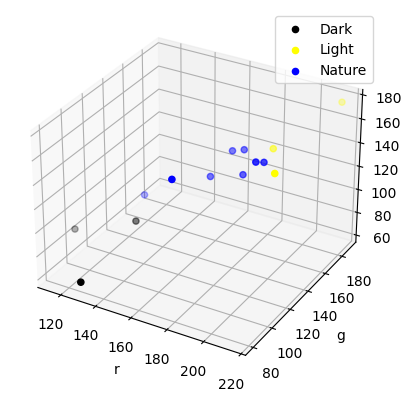

In [37]:
# Create a 3D scatter plot
colors = {'Dark': 'black', 'Light': 'yellow', 'Nature': 'blue'}
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for target, color in colors.items():
    ax.scatter(df[df['Target'] == target]['r'], 
               df[df['Target'] == target]['g'], 
               df[df['Target'] == target]['b'], 
               c=color, 
               label=target)
ax.set_xlabel('r')
ax.set_ylabel('g')
ax.set_zlabel('b')
ax.legend()
plt.show()

In [41]:
x = df[['r', 'g', 'b']]
y = df['Target']

# Split 
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

# Create a KNeighborsClassifier 
knn = KNeighborsClassifier(n_neighbors=3)

# Train 
knn.fit(X_train, y_train)

# predictions 
y_pred = knn.predict(X_test)

# classification report
print(classification_report(y_test, y_pred,zero_division=1))


              precision    recall  f1-score   support

        Dark       1.00      1.00      1.00         1
       Light       1.00      0.00      0.00         1
      Nature       0.75      1.00      0.86         3

    accuracy                           0.80         5
   macro avg       0.92      0.67      0.62         5
weighted avg       0.85      0.80      0.71         5



In [72]:
detect('dataset/1.jpg')
scale1('detected_skin.jpg')
getRGB('scale_image.jpg')

c:\Users\WINDOWS10\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(214, 176, 153)

In [73]:
rgb_values = getRGB('scale_image.jpg')
skin1 = [[rgb_values[0], rgb_values[1], rgb_values[2]]] # Converto to a list
predict_skintone = knn.predict(skin1)
print(predict_skintone)

['Light']


c:\Users\WINDOWS10\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
